# 30-modeling-h2o

> Outline and functionality for modeling with h2o

In this notebook, we use the composed dataframe (following feature selection and engineering) to generate h2o models using AutoML, predict, and evaluate their performance.  This notebook contains functionality which will allow standardized evaluations across differing modeling approaches.  We start off with AutoML to gauge the validity of this approach for modeling Covid risk.

In [1]:
#export
#data science
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from imblearn.over_sampling import RandomOverSampler

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#python
import os
import warnings
import glob
import subprocess
from datetime import date

#### Training settings

In [2]:
seed = 24
train_ratio = 0.8
test_ratio = 1-train_ratio

In [3]:
cleaned_data_filename = 'C://Users/kingl/Desktop/Projects/case_studies_fall21/DS5360_case1_team3/data/after_feature_engineering_dataset.csv'

# Read sample data
Note that here, we'll read an intermediate version of the final dataframe to test the behavior of the code.  If you encounter `DTypeWarning` issues, see more [here](https://github.com/pandas-dev/pandas/issues/10205) which may help describe the behavior.

In [4]:
full_df = pd.read_csv(cleaned_data_filename, dtype={'patient_id': 'category', 
                                                    'sars_cov_2_exam_result': 'category', 
                                                    'respiratory_syncytial_virus': 'category',
                                                    'influenza_a': 'category',
                                                    'rhinovirus_enterovirus': 'category',
                                                    'coronavirus_hku1': 'category',
                                                    'adenovirus': 'category',
                                                    'parainfluenza_4': 'category',
                                                    'inf_a_h1n1_2009': 'category',
                                                    'metapneumovirus': 'category',
                                                    'influenza_a_rapid_test': 'category',
                                                    'patient_had_blood_test': 'category',
                                                    'patient_had_urine_test': 'category'}).drop(columns = ['patient_addmited_to_regular_ward_1_yes_0_no','patient_addmited_to_semi_intensive_unit_1_yes_0_no','patient_addmited_to_intensive_care_unit_1_yes_0_no'])
print('Data shape: ', full_df.shape)
full_df.head()

Data shape:  (5644, 27)


,patient_id,patient_age_quantile,sars_cov_2_exam_result,hematocrit,hemoglobin,platelets,mean_platelet_volume,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,...,adenovirus,parainfluenza_4,inf_a_h1n1_2009,metapneumovirus,urea,creatinine,potassium,influenza_a_rapid_test,patient_had_blood_test,patient_had_urine_test
0,44477f75e8169d2,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,126e9dd13932f68,17,0,0.236515,-0.02234,-0.517413,0.010677,0.318366,-0.95079,-0.09461,...,0,0,0,0,1.198059,2.089928,-0.305787,0,1,1
2,a46b4402a0e5696,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,f7d619a94f97c45,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,d9e41465789c2b5,15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0


In [12]:
na_cols = full_df.columns[full_df.isna().any()].tolist()

In [13]:
numeric_fill = full_df[na_cols].select_dtypes(include='float64').mean()
category_fill = full_df[na_cols].select_dtypes(include='category').fillna("0")

In [15]:
full_df = full_df.fillna(numeric_fill).fillna(category_fill)

In [16]:
#view column info
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 27 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   patient_id                                      5644 non-null   category
 1   patient_age_quantile                            5644 non-null   int64   
 2   sars_cov_2_exam_result                          5644 non-null   category
 3   hematocrit                                      5644 non-null   float64 
 4   hemoglobin                                      5644 non-null   float64 
 5   platelets                                       5644 non-null   float64 
 6   mean_platelet_volume                            5644 non-null   float64 
 7   lymphocytes                                     5644 non-null   float64 
 8   mean_corpuscular_hemoglobin_concentration_mchc  5644 non-null   float64 
 9   leukocytes                    

Below is some simple preprocessing in case that we want to do anything to work on NA values, etc.  Right now, it just ensures that there are no NA values in the response variable, although from the data above, it seems like there aren't any.

In [17]:
#export
def simple_preprocessing(in_df):
    '''
    Function simple_processing: returns a pandas dataframe with minimally no NAs in the response column
        Inputs: in_df: pandas dataframe
        Returns: pre-processed dataframe with no NAs in the outcome variable
    '''
    
    #drop null outcomes
    out_df = in_df.dropna(subset=['sars_cov_2_exam_result'])
    
#     #simplify column names
#     out_df.rename(columns={'practice_squad_probability':'overall_pracsquad_prob', 'team_year_practice_squad_probability':'team_pracsquad_prob'}, inplace=True)
    
    #other things that we might decide (e.g., NA remedying)
    
    #return
    return out_df

In [18]:
modeling_df = simple_preprocessing(full_df)
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5644 entries, 0 to 5643
Data columns (total 27 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   patient_id                                      5644 non-null   category
 1   patient_age_quantile                            5644 non-null   int64   
 2   sars_cov_2_exam_result                          5644 non-null   category
 3   hematocrit                                      5644 non-null   float64 
 4   hemoglobin                                      5644 non-null   float64 
 5   platelets                                       5644 non-null   float64 
 6   mean_platelet_volume                            5644 non-null   float64 
 7   lymphocytes                                     5644 non-null   float64 
 8   mean_corpuscular_hemoglobin_concentration_mchc  5644 non-null   float64 
 9   leukocytes                    

---
# Split and encode data
For modeling, h2o will provide the best performance of this preliminary investigation until more aggressive selection and tuning is desired.  We'll focus on this approach for now.  A first step will be that we'll need to split the train/test data using stratification.

In [19]:
modeling_df['sars_cov_2_exam_result'].value_counts().sort_index()

0    5086
1     558
Name: sars_cov_2_exam_result, dtype: int64

In [20]:
#export
def stratify_oversample_split(in_df):
    '''
    Function stratify_split: splits a dataframe into training and testing sets while stratifying the outcome variable and oversampling on the training set
        Inputs: in_df: pandas dataframe 
        Outputs: training set, test set
    '''
    
    positive = in_df[in_df['sars_cov_2_exam_result']=='1']
    negative = in_df[in_df['sars_cov_2_exam_result']=='0']
    
    pos_train_index = list(positive.sample(frac=train_ratio, replace=False, random_state=seed).index)
    pos_train = positive[positive.index.isin(pos_train_index)]
    pos_test = positive[~positive.index.isin(pos_train_index)]

    neg_train_index = list(negative.sample(frac=train_ratio, replace=False, random_state=seed).index)
    neg_train = negative[negative.index.isin(neg_train_index)]
    neg_test = negative[~negative.index.isin(neg_train_index)]

    train_data_strat = pd.concat([pos_train, neg_train]).reset_index(drop = True)
    test_data = pd.concat([pos_test, neg_test]).reset_index(drop = True)
    
    train_x, train_y = RandomOverSampler().fit_resample(train_data_strat.drop('sars_cov_2_exam_result', axis=1), train_data_strat['sars_cov_2_exam_result'])
    train_x.insert(2, 'sars_cov_2_exam_result', train_y)
    
    train_data = train_x
    
    return train_data, test_data

In [21]:
train_df, test_df = stratify_oversample_split(modeling_df)

In [22]:
train_df

,patient_id,patient_age_quantile,sars_cov_2_exam_result,hematocrit,hemoglobin,platelets,mean_platelet_volume,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,...,adenovirus,parainfluenza_4,inf_a_h1n1_2009,metapneumovirus,urea,creatinine,potassium,influenza_a_rapid_test,patient_had_blood_test,patient_had_urine_test
0,78511c183ae18bc,7,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
1,d7834ed75f2da44,16,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
2,b16b49f7bd3e692,10,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
3,4382f5ea05e60c4,2,1,9.918382e-01,7.921876e-01,-3.415477e-01,1.469188e+00,-4.838327e-02,-4.528995e-01,-4.201970e-01,...,0,0,0,0,-5.139092e-01,-3.223401e-01,-5.862590e-02,0,1,1
4,ab9745da9d139b9,15,1,-4.959191e-01,-3.982758e-01,-7.184020e-01,-4.380969e-01,-9.354039e-01,2.441486e-01,-8.209189e-01,...,0,0,0,0,9.747588e-01,1.601135e-01,-1.047272e+00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8133,5c493f44b830ac3,9,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
8134,48f4e7a52d6b377,6,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
8135,50c45c8d5f44e36,12,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
8136,11b940d108ad511,9,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0


Let's make sure that this is working:

In [23]:
print('Train positive proportion: ')
display(len(train_df[train_df['sars_cov_2_exam_result'] == '1'])/len(train_df))
print('\nTest positive proportion: ')
len(test_df[test_df['sars_cov_2_exam_result'] == '1'])/len(test_df)

Train positive proportion: 


0.5


Test positive proportion: 


0.09920283436669619

Looks good.  Here is a preview of the two datasets:

In [24]:
print('Train sample: ')
display(train_df.head())
print('\n Test sample: ')
test_df.head()

Train sample: 


,patient_id,patient_age_quantile,sars_cov_2_exam_result,hematocrit,hemoglobin,platelets,mean_platelet_volume,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,...,adenovirus,parainfluenza_4,inf_a_h1n1_2009,metapneumovirus,urea,creatinine,potassium,influenza_a_rapid_test,patient_had_blood_test,patient_had_urine_test
0,78511c183ae18bc,7,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
1,d7834ed75f2da44,16,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
2,b16b49f7bd3e692,10,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
3,4382f5ea05e60c4,2,1,9.918382e-01,7.921876e-01,-3.415477e-01,1.469188e+00,-4.838327e-02,-4.528995e-01,-4.201970e-01,...,0,0,0,0,-5.139092e-01,-3.223401e-01,-5.862590e-02,0,1,1
4,ab9745da9d139b9,15,1,-4.959191e-01,-3.982758e-01,-7.184020e-01,-4.380969e-01,-9.354039e-01,2.441486e-01,-8.209189e-01,...,0,0,0,0,9.747588e-01,1.601135e-01,-1.047272e+00,0,1,1



 Test sample: 


,patient_id,patient_age_quantile,sars_cov_2_exam_result,hematocrit,hemoglobin,platelets,mean_platelet_volume,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,...,adenovirus,parainfluenza_4,inf_a_h1n1_2009,metapneumovirus,urea,creatinine,potassium,influenza_a_rapid_test,patient_had_blood_test,patient_had_urine_test
0,d3729cd2658ca64,15,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
1,ff5ec3abd7d6088,5,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
2,1e7e33688edc5a9,11,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
3,bbc031943952afa,10,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0
4,e00ef039cdb2b3e,7,1,-2.187396e-09,-1.598342e-08,-3.820598e-10,7.373957e-09,-7.863787e-09,9.784053e-10,6.218887e-09,...,0,0,0,0,-6.707809e-09,-6.669811e-09,2.053100e-08,0,0,0


Here's some info on the sizes:

In [25]:
print('Training set shape: ', train_df.shape)
print('Testing set shape: ', test_df.shape)

Training set shape:  (8138, 27)
Testing set shape:  (1129, 27)


---
# h2o modeling
In this step, we use h2o to perform the modeling, and specifically, we use AutoML.  AutoML performs a bit of hyperparameter tuning depending on the model type and runs through several model types in order to identify the best model.

## Setup and init
Here, we make some autorun settings for H2o and initialize our local server...

In [26]:
max_models = None
max_runtime_mins = 1

In [27]:
#initialize h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\kingl\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kingl\AppData\Local\Temp\tmpyr4tdz8f
  JVM stdout: C:\Users\kingl\AppData\Local\Temp\tmpyr4tdz8f\h2o_kingl_started_from_python.out
  JVM stderr: C:\Users\kingl\AppData\Local\Temp\tmpyr4tdz8f\h2o_kingl_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,5 months and 4 days !!!
H2O_cluster_name:,H2O_from_python_kingl_nlyjug
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.939 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


---
## Data organization
Now, we're going to use the original data without the encodings.  H2o is an industry-level modeling framework, and performs its own encodings to maximize efficiently.  H2o also likes to receive its data a little differently structured than scikit-learn.

Here, we convert to the required h2o data structure, and we need to make sure to specify categorical encodings.  The way that we can make sure that this is done by h2o is by setting those columns to be factors.  This is performed below.

In [28]:
#export
def fix_h2o_encodings(in_df, verbose=False):
    '''
    Function fix_h2o_encodings: returns an h2o frame with the same variables as the input dataframe, ensuring matching of datatypes
        Inputs: in_df: pandas dataframe
                verbose (default False): If True, prints information about the column types for the output frame
        Returns: h2o data structure (H2OFrame) of input dataframe
    '''
    
    #convert dataframe to h2o frame
    h2o_frame = h2o.H2OFrame(in_df)
    
    #get datatypes of the input dataframe
    df_dtypes = in_df.dtypes.to_dict()
    
    #fix dtypes of h2o frame
    for col, col_type in df_dtypes.items():
        if col_type.name =='category':
            if verbose: print('Is factor:', col)
            h2o_frame[col] = h2o_frame[col].asfactor()
        else:
            if verbose: print('Is numeric:', col)
            h2o_frame[col] = h2o_frame[col].asnumeric()
    
    return h2o_frame

We convert the dataframes below.  In the second example, we use `verbose=True` to demonstrate the columns which are converted.  Note that the names are present here; we won't want to include this in the modeling so we can remove this in later modeling steps.  For now, we'll just keep it.

In [29]:
train_h2o = fix_h2o_encodings(train_df, verbose=True)
test_h2o = fix_h2o_encodings(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Is factor: patient_id
Is numeric: patient_age_quantile
Is factor: sars_cov_2_exam_result
Is numeric: hematocrit
Is numeric: hemoglobin
Is numeric: platelets
Is numeric: mean_platelet_volume
Is numeric: lymphocytes
Is numeric: mean_corpuscular_hemoglobin_concentration_mchc
Is numeric: leukocytes
Is numeric: basophils
Is numeric: eosinophils
Is numeric: monocytes
Is factor: respiratory_syncytial_virus
Is factor: influenza_a
Is factor: rhinovirus_enterovirus
Is factor: coronavirus_hku1
Is factor: adenovirus
Is factor: parainfluenza_4
Is factor: inf_a_h1n1_2009
Is factor: metapneumovirus
Is numeric: urea
Is numeric: creatinine
Is numeric: potassium
Is factor: influenza_a_rapid_test
Is factor: patient_had_blood_test
Is factor: patient_had_urine_test
Parse progress: |█████████████████████████████████████████████████████████| 100%


---
## Train h2o model
In this step, we train the model.  This will involve a simple train/valid split, and the way to do this can be seen in the cell below. We'll start with simplest first, though, even though this will likely lead to slightly optimistic results.

We'll also set the columns which will be used for prediction and the column which will be predicted.  We use AutoML to run through a number of variables, and we allow this to train by our specified `max_runtime_mins` setting.  Note that allowing this to run longer may generate better models.  The leaderboard shows all the models and their performance, ordered by the best first.

In [30]:
#export
def train_h2o_model(h2o_train, exclude_cols=[], train_mins=1, seed = 2435, verbose=False, **aml_kwargs):
    '''
    Function train_h2o_model: trains AutoML h2o model, excluding columns in the dataframe which are unwanted, returning leaderboard and best model
        Inputs: h2o_train: H2OFrame of training data (including response variable)
                exclude_columns (default []): list of column names (strings) which you do not want to include in the model
                train_mins (default 1): integer of how many minutes you'd like to run AutoML for
                seed (default 2435): integer of seed for reproducibility
                verbose (default False): If True, prints the predictors and response variables used in the modeling
                **aml_kwargs: keyword settings to be passed to H2OAutoML function
        Returns: H2o leader model, full AutoML model set
    '''
    
    #response
    response = 'sars_cov_2_exam_result'
    
    #predictors to be excluded
    all_preds = h2o_train.columns
    ids_exclude = ['patient_id']
    all_exclude = ids_exclude + exclude_cols + [response]
    
    #exclude some predictors
    predictors = [preds for preds in all_preds if preds not in all_exclude]
    
    #print maybe
    if verbose:
        print('Predictors: ', predictors)
        print('Response: ', response)
    
    #train model
    aml = H2OAutoML(max_runtime_secs = 60*train_mins, seed=seed, **aml_kwargs)
    aml.train(x=predictors, y=response, training_frame=h2o_train)
    
    #return the leader model and automl
    return aml.leader, aml

In [31]:
aml_leader, mls = train_h2o_model(train_h2o, exclude_cols=[], verbose=True)

Predictors:  ['patient_age_quantile', 'hematocrit', 'hemoglobin', 'platelets', 'mean_platelet_volume', 'lymphocytes', 'mean_corpuscular_hemoglobin_concentration_mchc', 'leukocytes', 'basophils', 'eosinophils', 'monocytes', 'respiratory_syncytial_virus', 'influenza_a', 'rhinovirus_enterovirus', 'coronavirus_hku1', 'adenovirus', 'parainfluenza_4', 'inf_a_h1n1_2009', 'metapneumovirus', 'urea', 'creatinine', 'potassium', 'influenza_a_rapid_test', 'patient_had_blood_test', 'patient_had_urine_test']
Response:  sars_cov_2_exam_result
AutoML progress: |
14:54:53.85: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [32]:
mls.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20211004_145453,0.742262,0.545974,0.737086,0.334357,0.438992,0.192714
GBM_3_AutoML_20211004_145453,0.742234,0.554015,0.737051,0.336201,0.440682,0.1942
GBM_grid__1_AutoML_20211004_145453_model_7,0.741939,0.552994,0.737822,0.335217,0.4407,0.194216
GBM_grid__1_AutoML_20211004_145453_model_1,0.741743,0.548827,0.735306,0.334603,0.439567,0.193219
GBM_grid__1_AutoML_20211004_145453_model_3,0.740721,0.550071,0.736019,0.336446,0.440266,0.193834
StackedEnsemble_BestOfFamily_AutoML_20211004_145453,0.740618,0.550196,0.736245,0.335463,0.440319,0.193881
GBM_4_AutoML_20211004_145453,0.740295,0.55406,0.735929,0.337184,0.440825,0.194327
GBM_grid__1_AutoML_20211004_145453_model_6,0.738872,0.555918,0.73341,0.338044,0.441748,0.195141
GBM_2_AutoML_20211004_145453,0.73848,0.56085,0.733943,0.338535,0.442667,0.195954
DRF_1_AutoML_20211004_145453,0.737967,0.560552,0.73681,0.338658,0.442934,0.196191


---
## Performance on training set
In this step, we evaluate the performance of the model on the training set.  We already actually see the performance of the model(s) on the training set in the step above by looking at the leaderboard.  However, we can explicitly generate these metrics.  The functions below are wrappers, which will allow us to use the same performance evaluation across all the modeling stages.  If we want to add on to these evaluations, we can add these steps into the functions below and re-run on previous models to evaluate the performance.  We can use these same functions on the test set.

Here, we can look at the performance on the training set.  Obviously, these results should not be considered to be the performance of the model, but represent how well the model trained.  We used these performance metrics already to select this model, but we can further investigate the performance on the training set using the functions below.

In [33]:
#export
def basic_performance(mdl, h2o_frame, show_outputs=False):
    '''
    Function basic_performance: shows/returns predictions and performance of the model on the input dataset
        Inputs: mdl: h2o model object
                h2o_frame: H2OFrame of train or test set (i.e., requires response variables to be included)
                show_outputs (default False): If True, prints the overall performance of the model on the dataset and a plot of RMSE distribution
        Returns: H2OMetrics object of performance metrics, pandas dataframe of predictions
    '''
    
    #get performance
    perf = mdl.model_performance(h2o_frame)
        
    #get predictions
    preds = mdl.predict(h2o_frame)
    
    #convert to regular python/pandas data structure
    yres = preds.as_data_frame()
    yres['actual'] = h2o_frame.as_data_frame()['sars_cov_2_exam_result']
    yres['rmse'] = np.sqrt((yres['predict'].values-yres['actual'].values)**2)
    yres = yres/1e6
    
    #show basic performance output if desired
    if show_outputs:
        
        #show output metrics
        display(perf)
        
#         #show output plot
#         plt.figure(figsize=(10,8))
#         plt.subplot(1,2,1)
#         res_plt = sns.violinplot(data=yres[['actual', 'predict']], cut=0);
#         plt.xlabel('Value Type')
#         plt.ylabel('Earnings (in millions)')
#         plt.title('Earnings Distributions');
#         plt.subplot(1,2,2)
#         plt2 = sns.violinplot(y=yres['rmse'], cut=0);
#         plt.xlabel('RMSE')
#         plt.ylabel('Earnings error(in millions)')
#         plt.title('Earnings Error Distributions');
#         plt.suptitle('Earnings Distributions')
#         display(res_plt);
    
    return perf, preds

In [34]:
train_perf, train_preds = basic_performance(aml_leader, train_h2o, show_outputs=True)

stackedensemble prediction progress: |████████████████████████████████████| 100%

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.18897789572032248
RMSE: 0.4347158793054637
LogLoss: 0.5345891273477688
Null degrees of freedom: 8137
Residual degrees of freedom: 8131
Null deviance: 11281.663510795215
Residual deviance: 8700.972636712284
AIC: 8714.972636712284
AUC: 0.755069968093397
AUCPR: 0.7519198313684469
Gini: 0.510139936186794

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41224215900621936: 


,,0,1,Error,Rate
0,0,1591.0,2478.0,0.609,(2478.0/4069.0)
1,1,208.0,3861.0,0.0511,(208.0/4069.0)
2,Total,1799.0,6339.0,0.3301,(2686.0/8138.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.412242,0.741929,77.0
1,max f2,0.317346,0.870289,81.0
2,max f0point5,0.529177,0.668507,70.0
3,max accuracy,0.510433,0.675227,72.0
4,max precision,0.998961,1.000000,0.0
5,max recall,0.047070,1.000000,129.0
6,max specificity,0.998961,1.000000,0.0
7,max absolute_mcc,0.412242,0.409540,77.0
8,max min_per_class_accuracy,0.540822,0.653478,68.0
9,max mean_per_class_accuracy,0.510433,0.675227,72.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011059,0.998644,2.000000,2.000000,1.000000,0.998809,1.000000,0.998809,0.022118,0.022118,100.000000,100.000000,0.022118
1,2,0.020275,0.998428,2.000000,2.000000,1.000000,0.998537,1.000000,0.998685,0.018432,0.040551,100.000000,100.000000,0.040551
2,3,0.031089,0.998261,2.000000,2.000000,1.000000,0.998310,1.000000,0.998555,0.021627,0.062177,100.000000,100.000000,0.062177
3,4,0.040551,0.998105,2.000000,2.000000,1.000000,0.998143,1.000000,0.998459,0.018924,0.081101,100.000000,100.000000,0.081101
4,5,0.050258,0.997620,2.000000,2.000000,1.000000,0.997869,1.000000,0.998345,0.019415,0.100516,100.000000,100.000000,0.100516
5,6,0.111944,0.660162,1.625498,1.793633,0.812749,0.792583,0.896817,0.884961,0.100270,0.200786,62.549801,79.363337,0.177685
6,7,0.177808,0.620869,1.250000,1.592260,0.625000,0.620869,0.796130,0.787136,0.082330,0.283116,25.000000,59.225985,0.210617
7,8,0.213935,0.617503,1.251701,1.534750,0.625850,0.617503,0.767375,0.758490,0.045220,0.328336,25.170068,53.475014,0.228803
8,9,0.324281,0.590820,1.216036,1.426298,0.608018,0.595864,0.713149,0.703152,0.134185,0.462522,21.603563,42.629784,0.276481
9,10,0.437085,0.582441,1.187364,1.364633,0.593682,0.582608,0.682317,0.672042,0.133940,0.596461,18.736383,36.463312,0.318752


---
## Model performance
Below is an example of an explanation from h2o.  This was performed on the training set.  This does not take a short time to run.  Make sure to set `render=False` if you don't want the plot to print twice.

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20211004_145453


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41224215900621936: 


,,0,1,Error,Rate
0,0,1591.0,2478.0,0.609,(2478.0/4069.0)
1,1,208.0,3861.0,0.0511,(208.0/4069.0)
2,Total,1799.0,6339.0,0.3301,(2686.0/8138.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

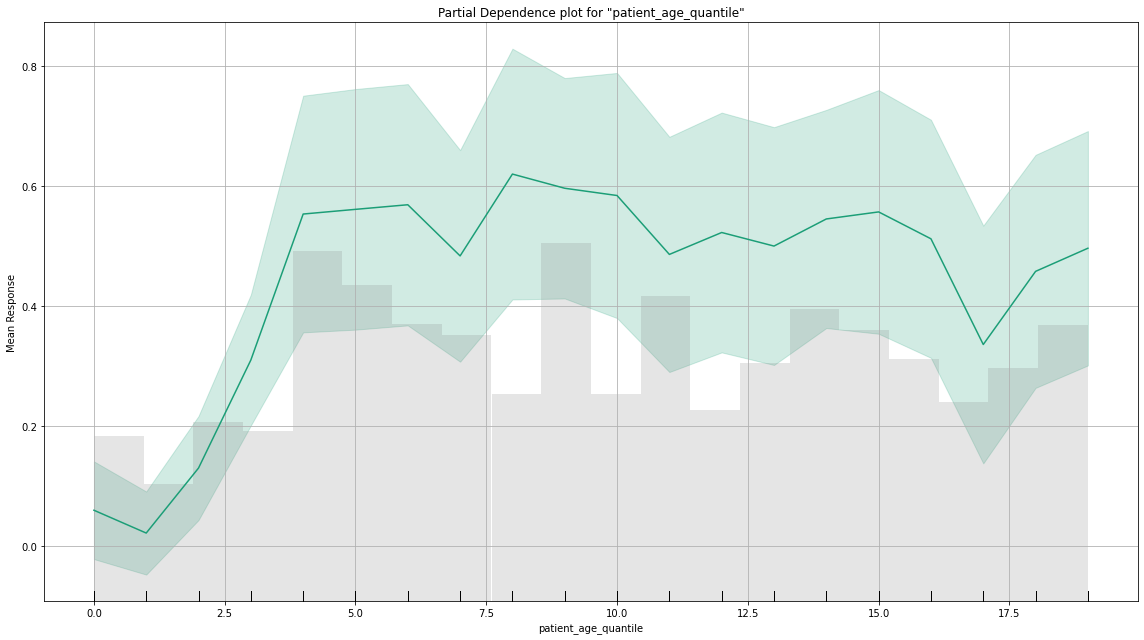

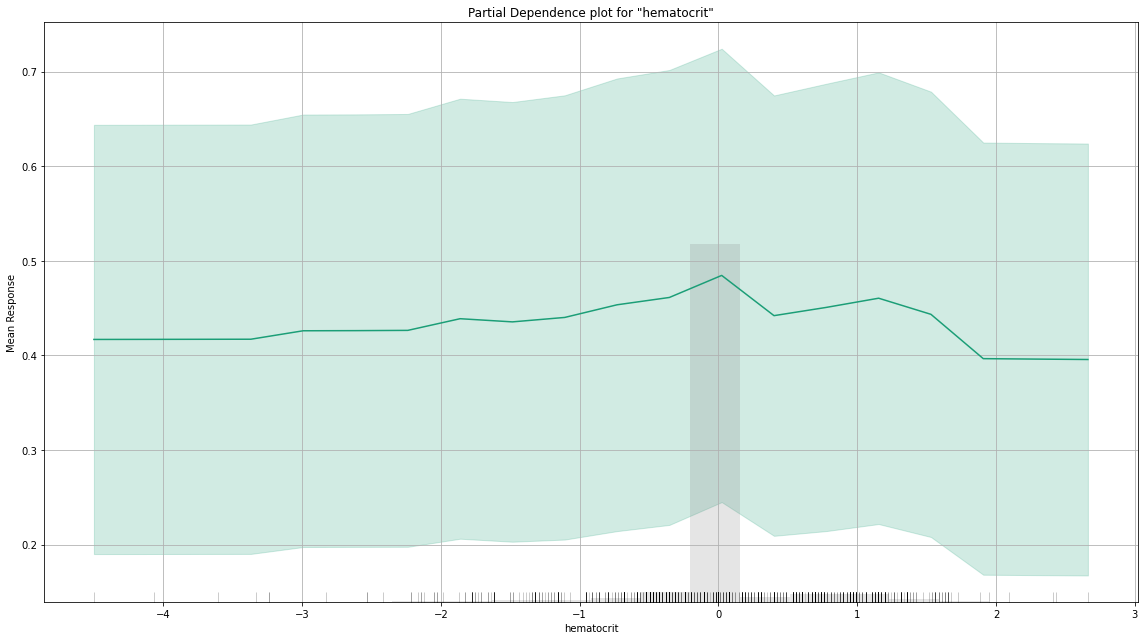

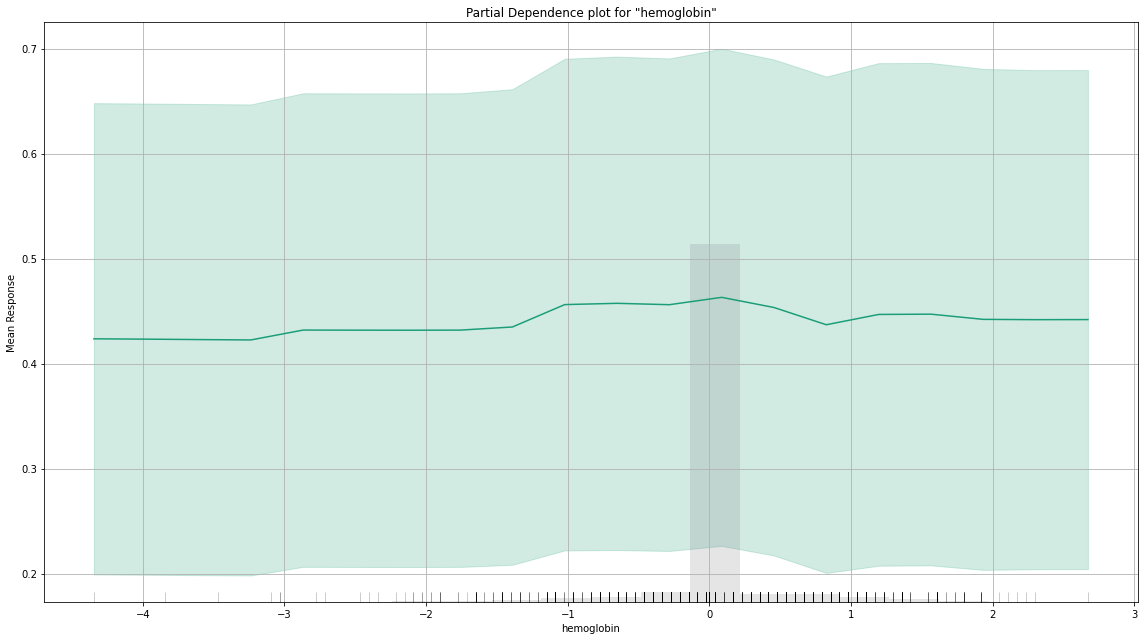

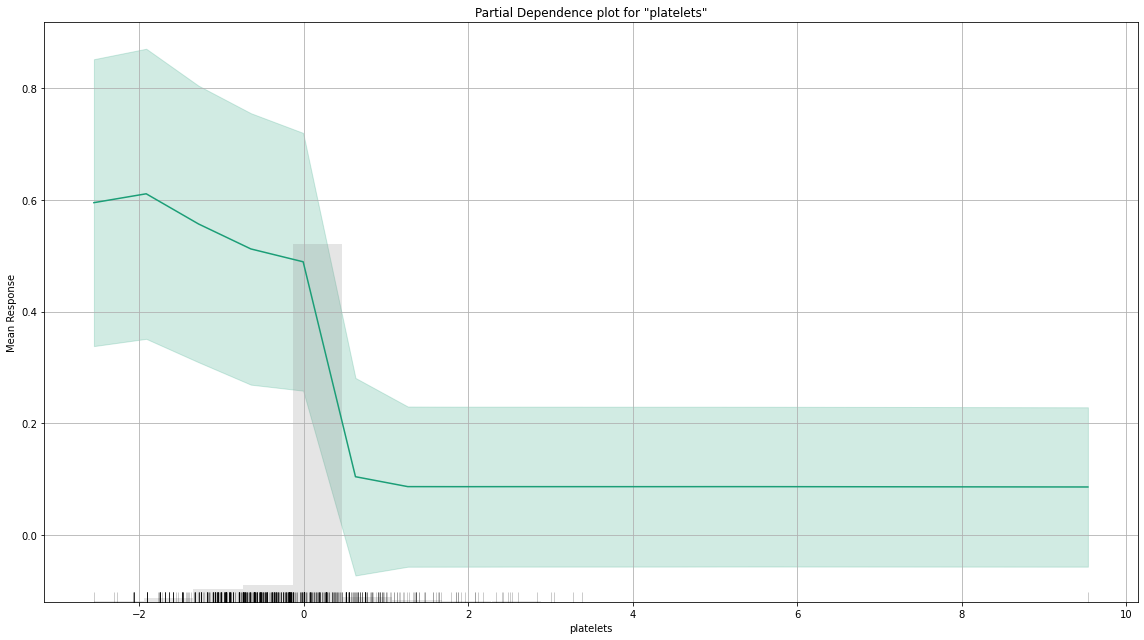

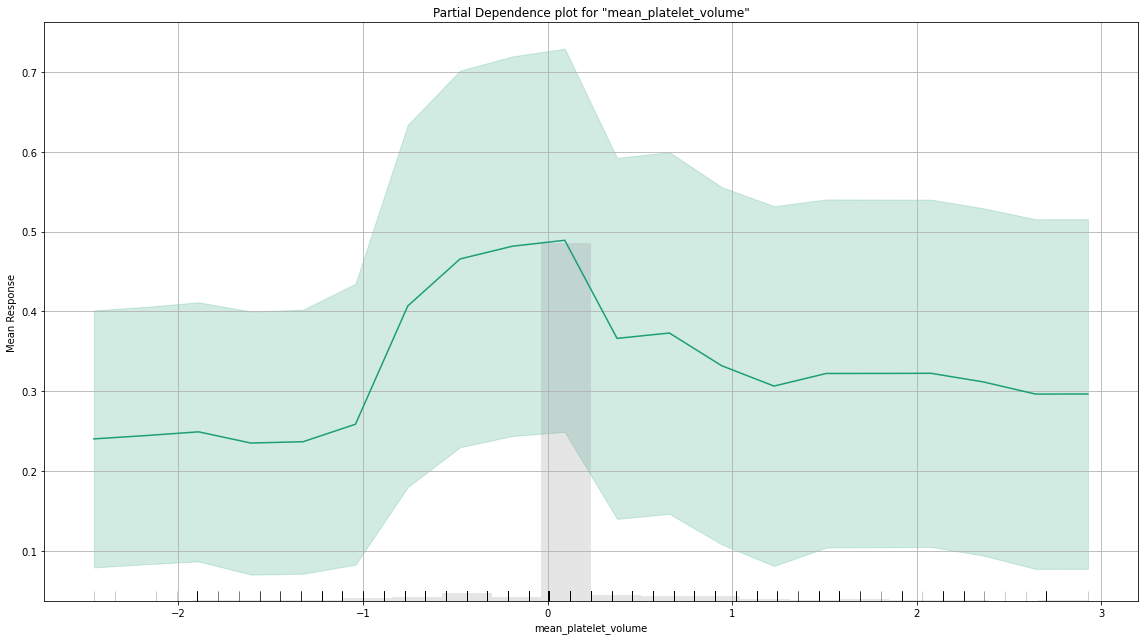

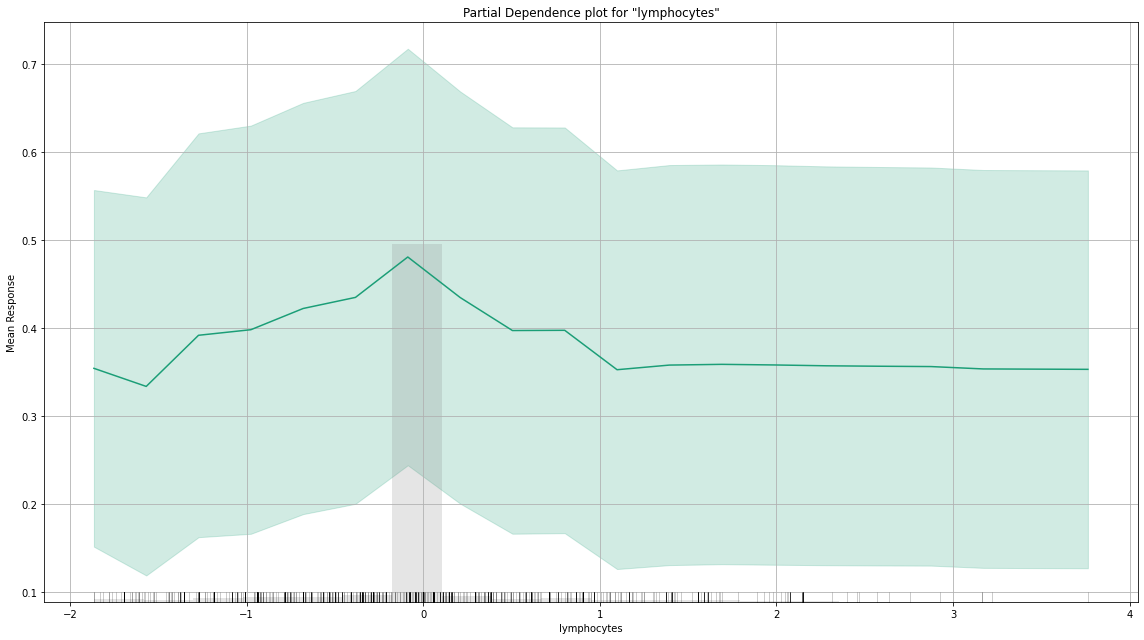

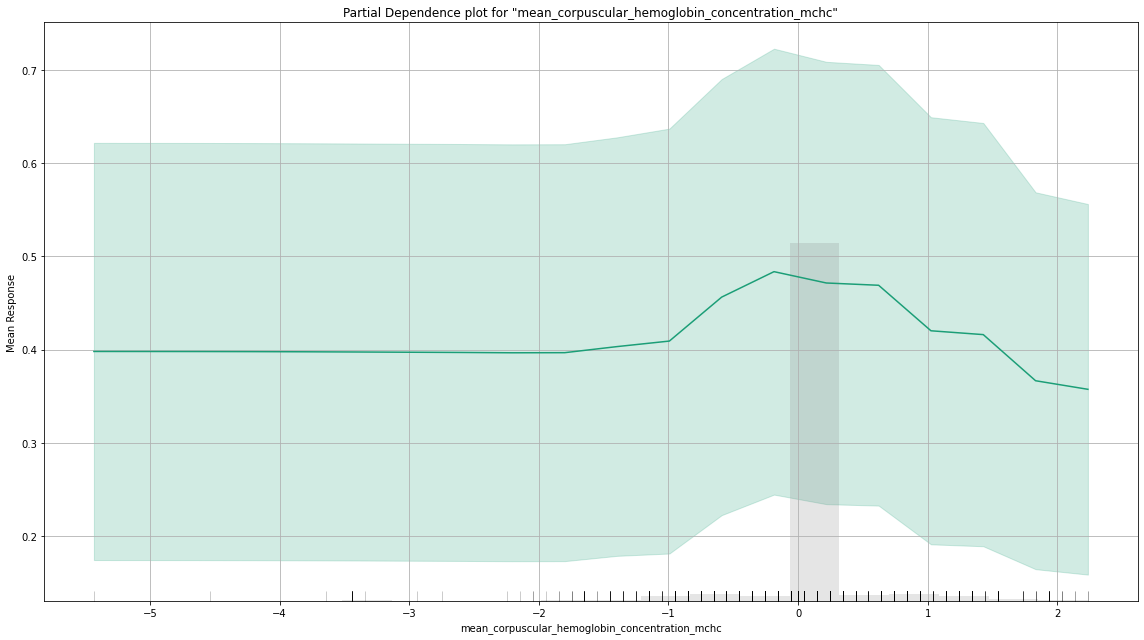

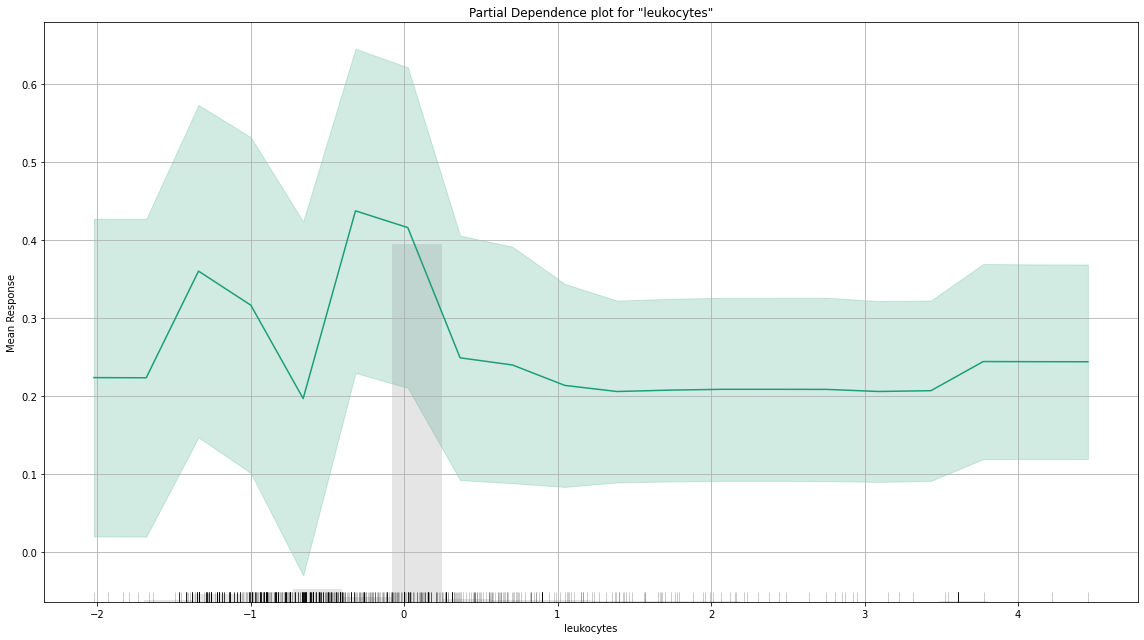

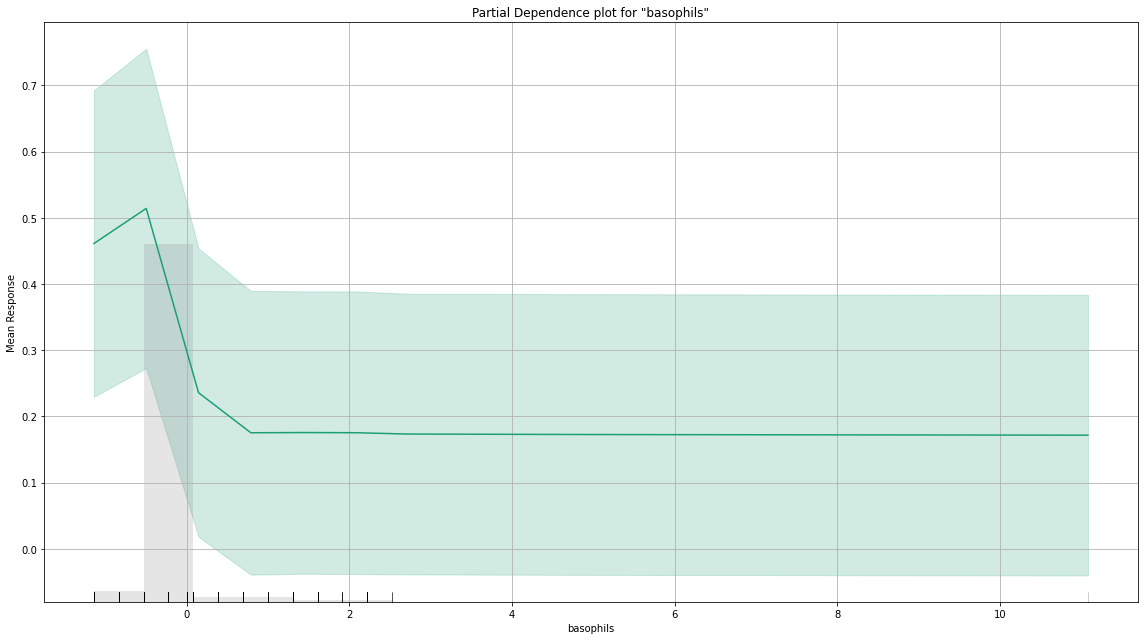

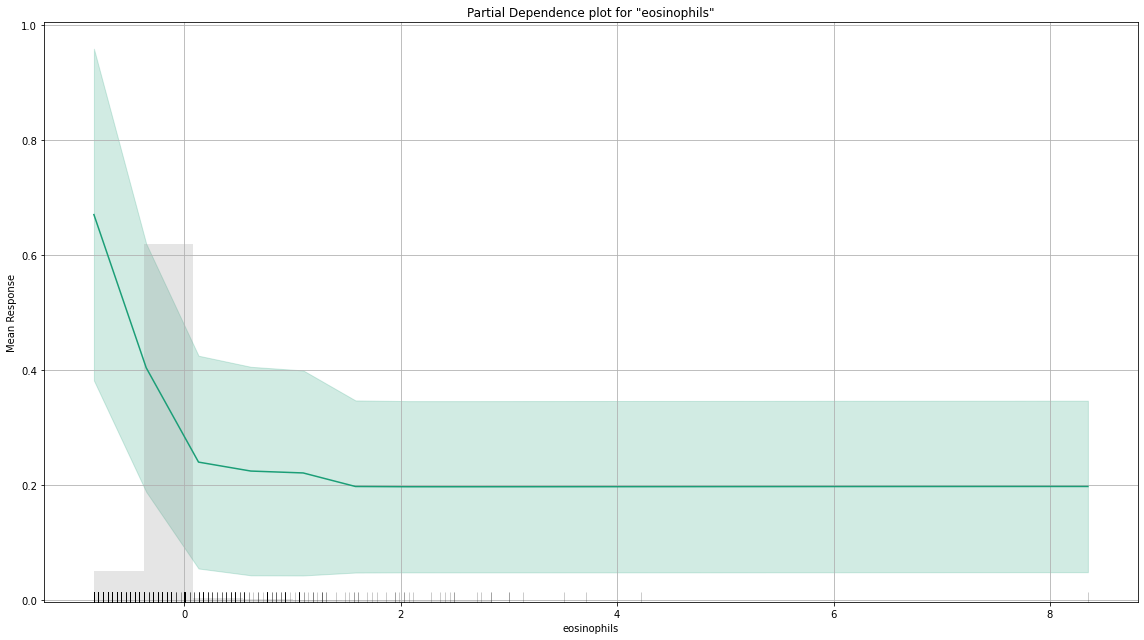

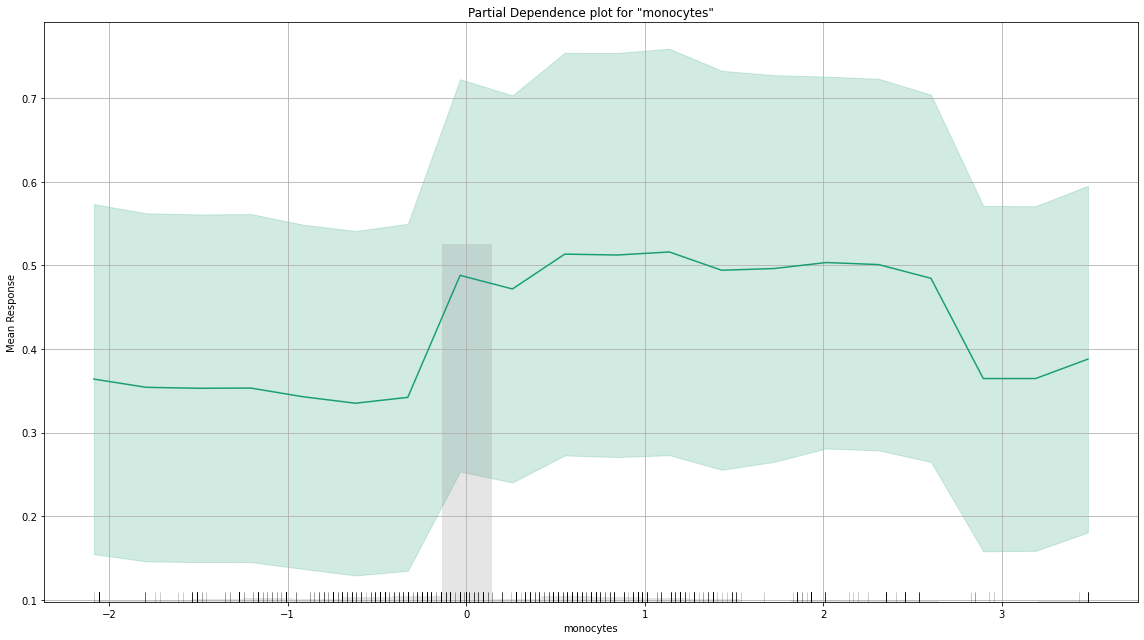

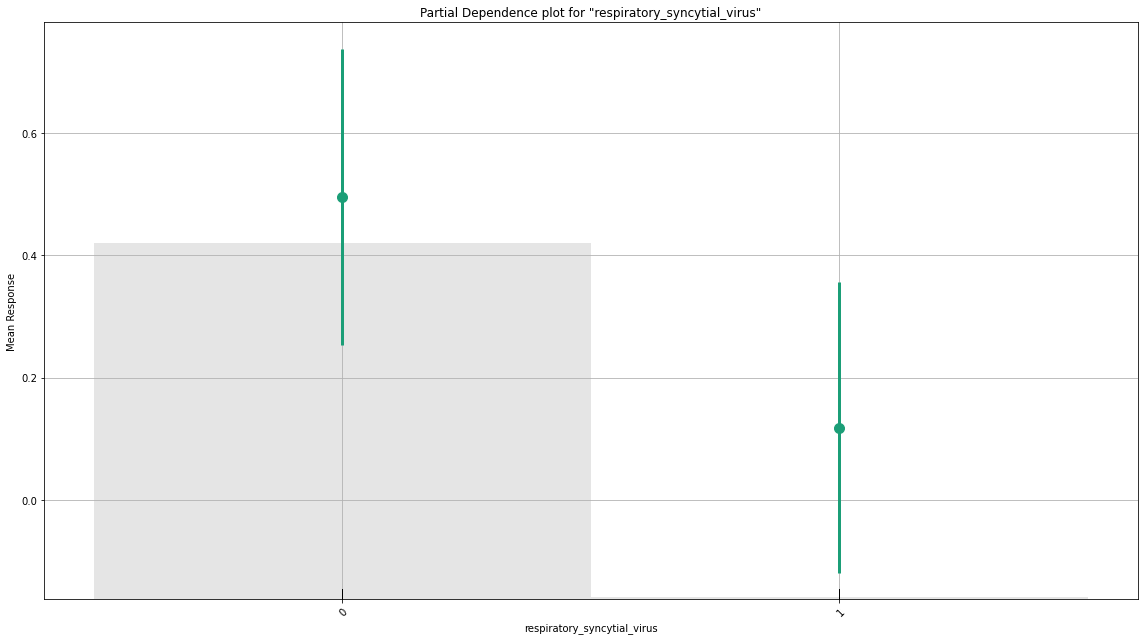

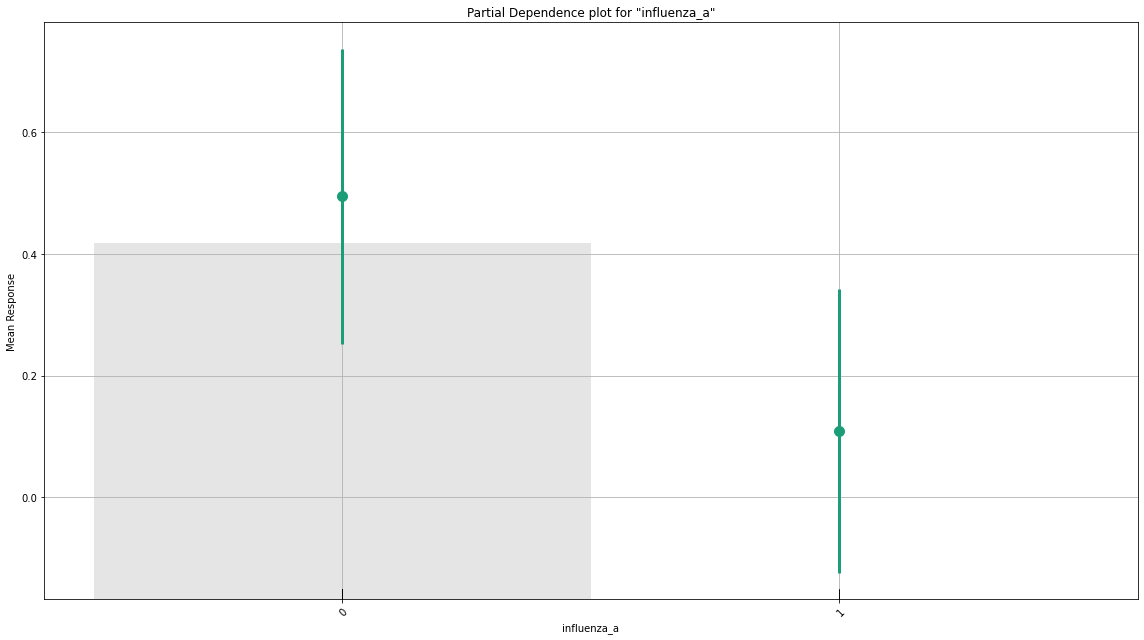

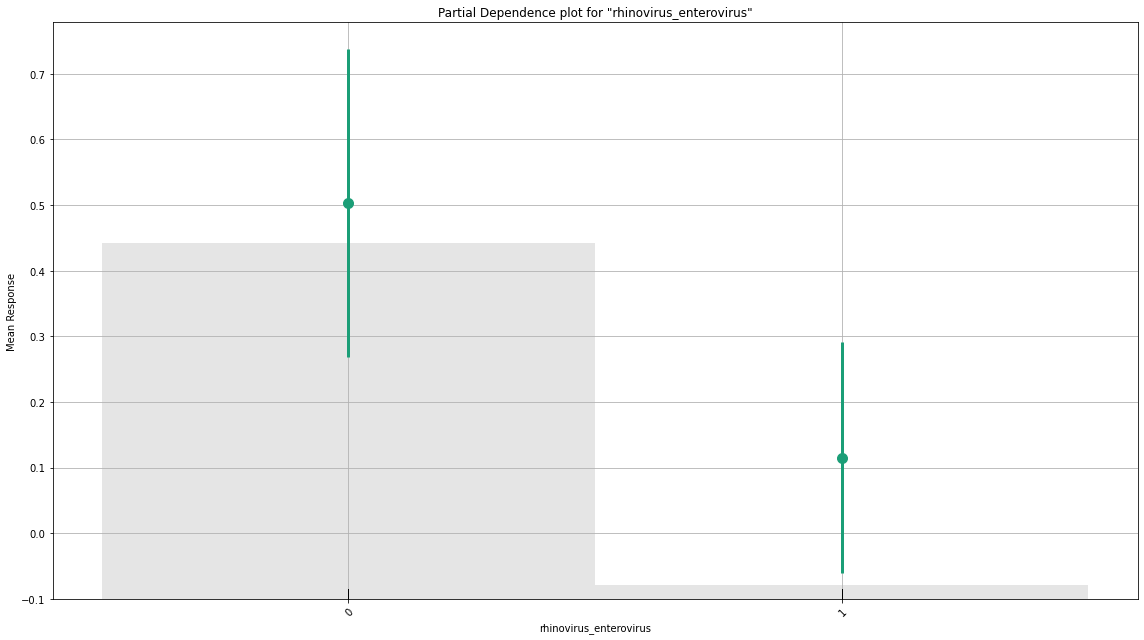

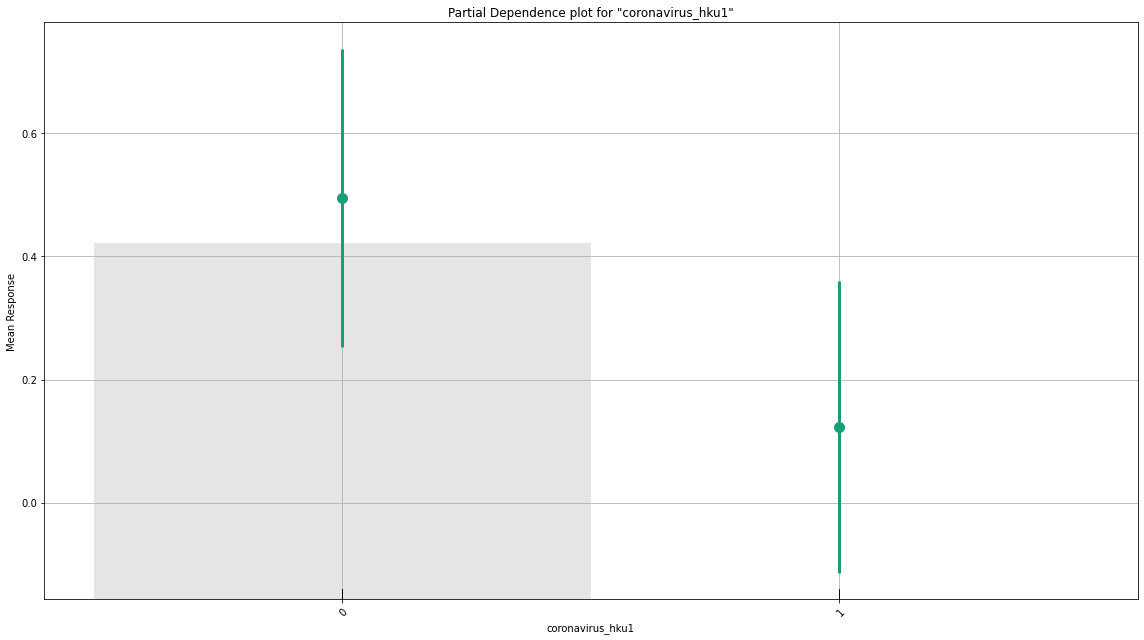

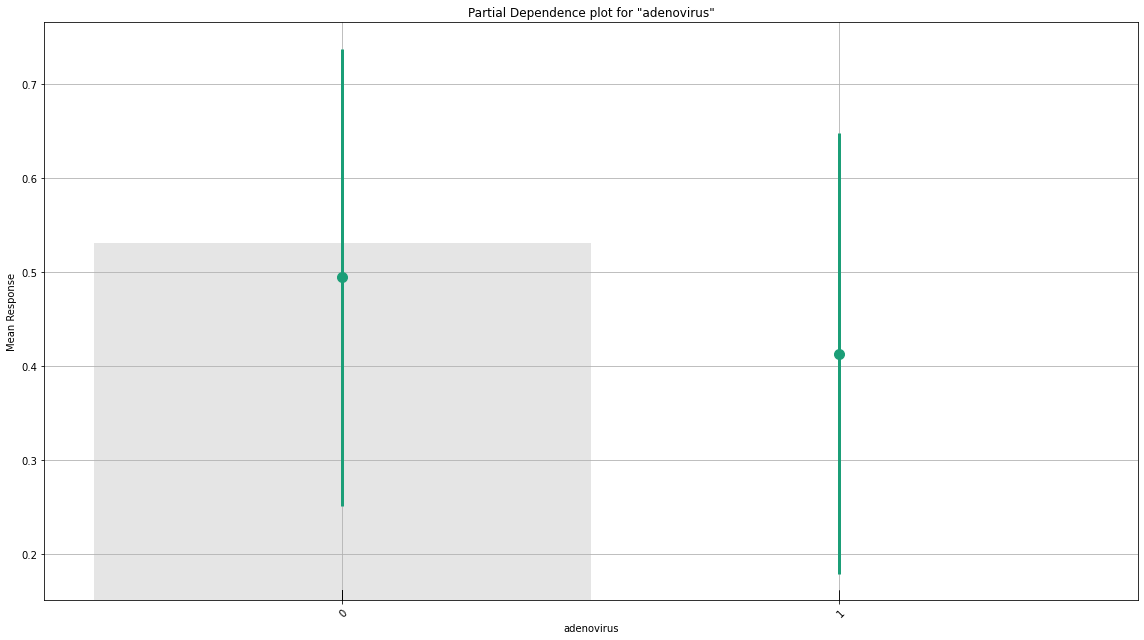

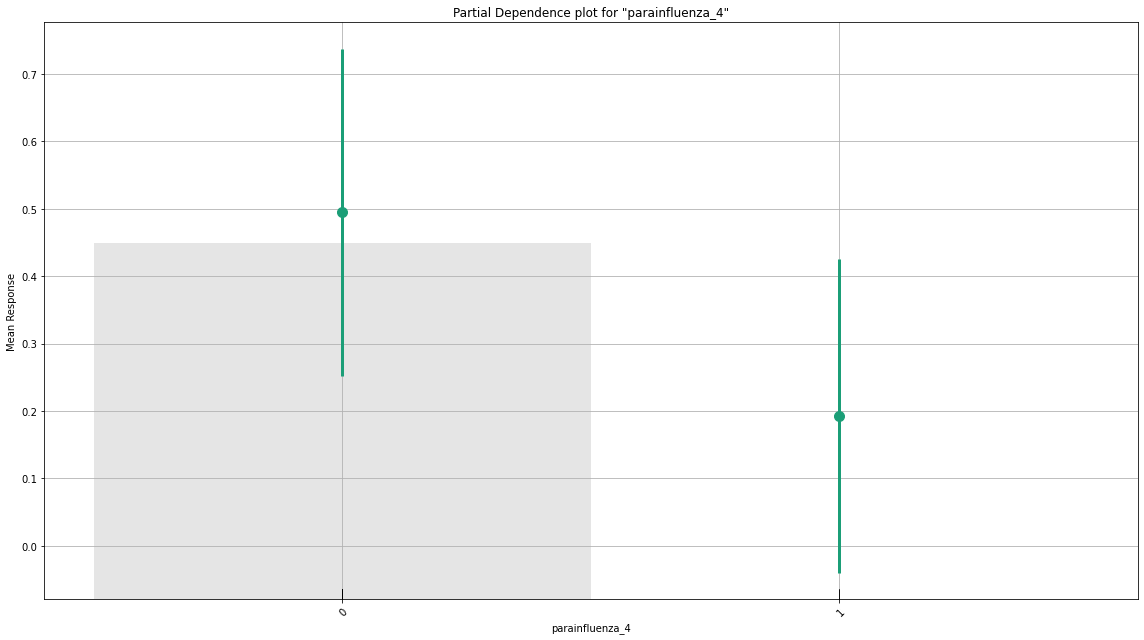

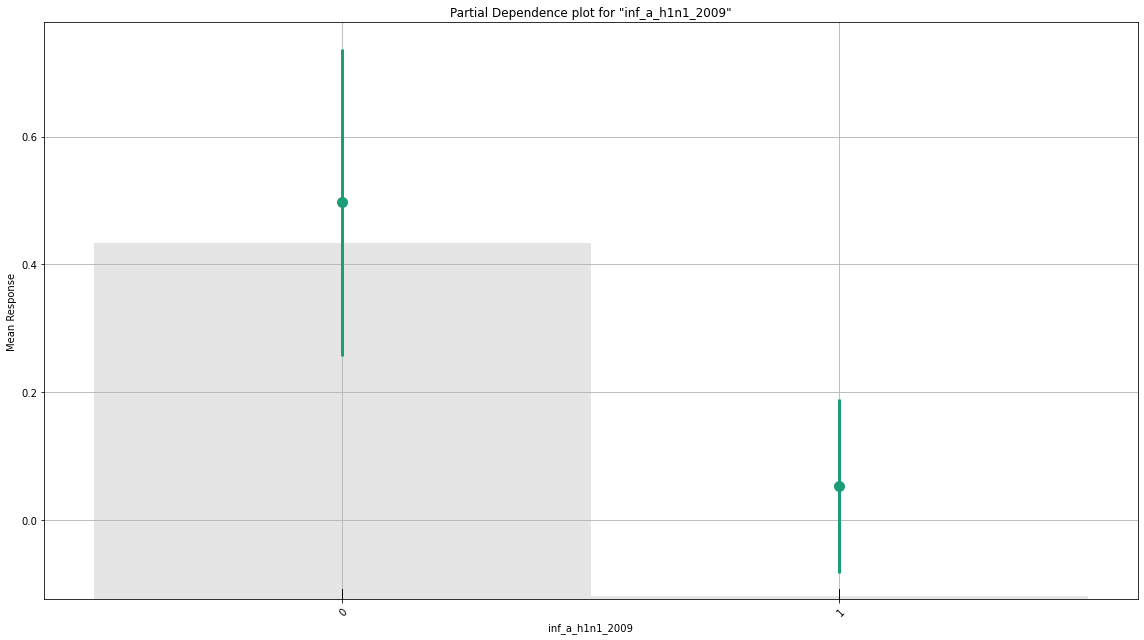

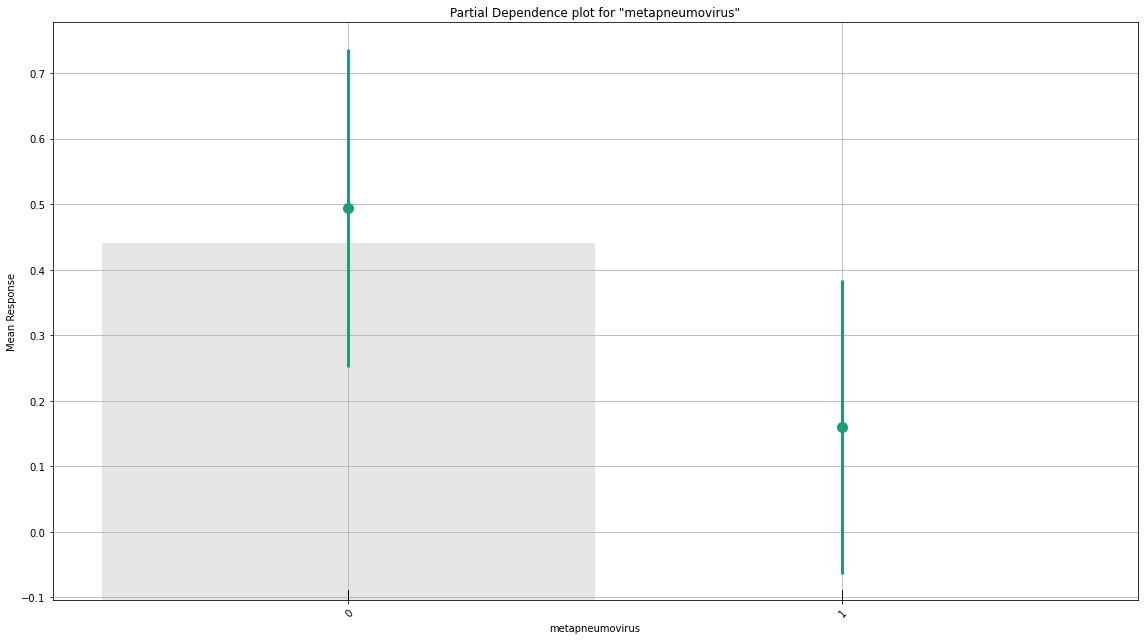

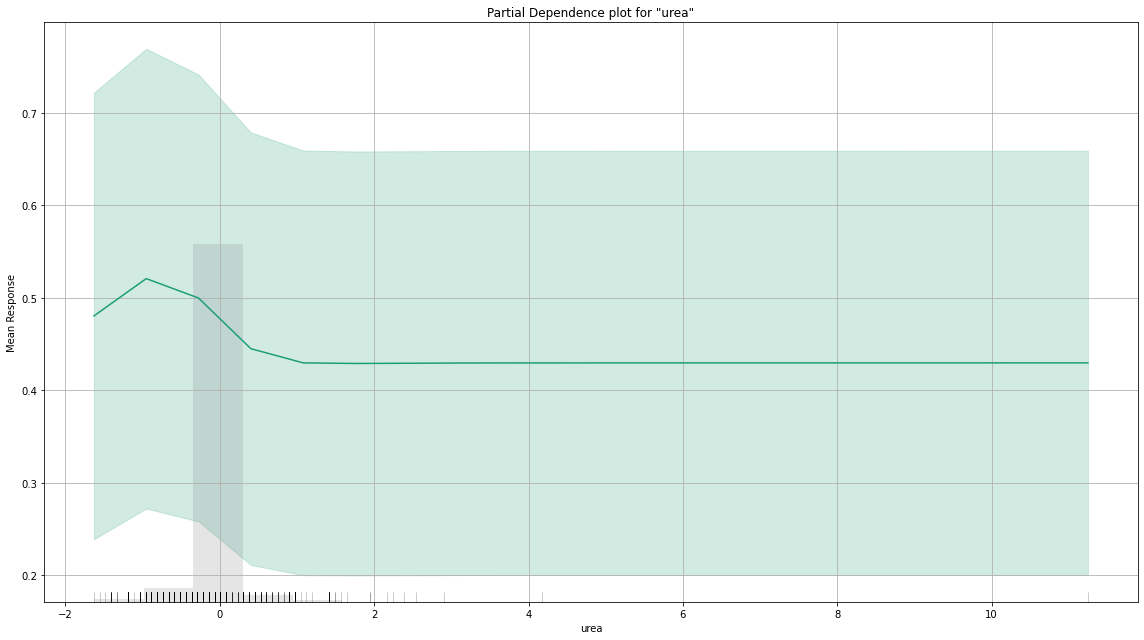

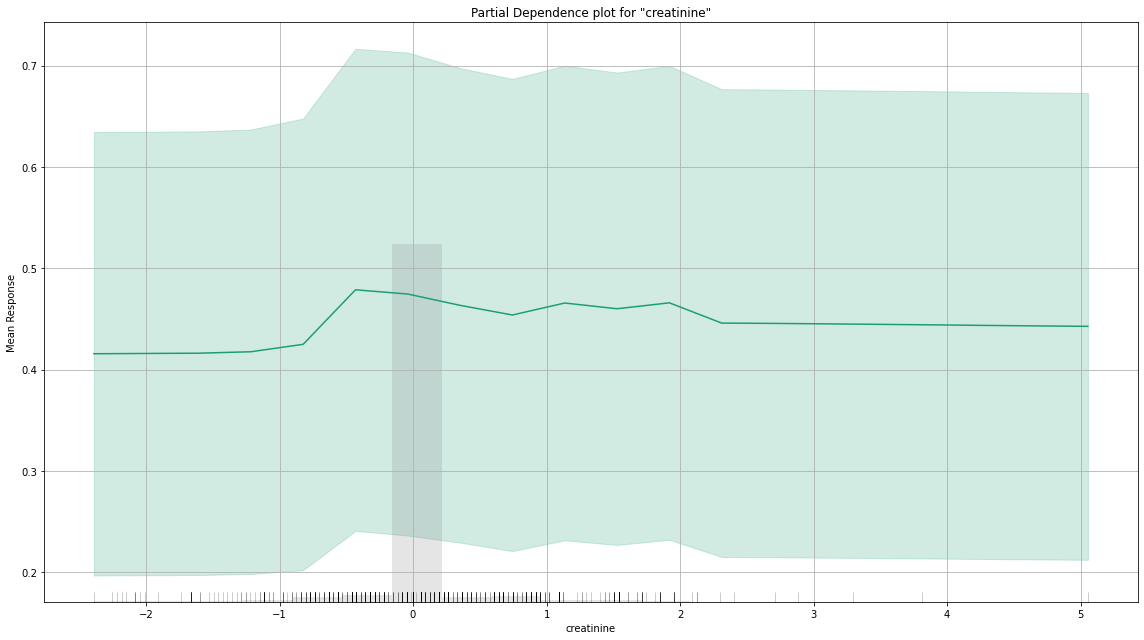

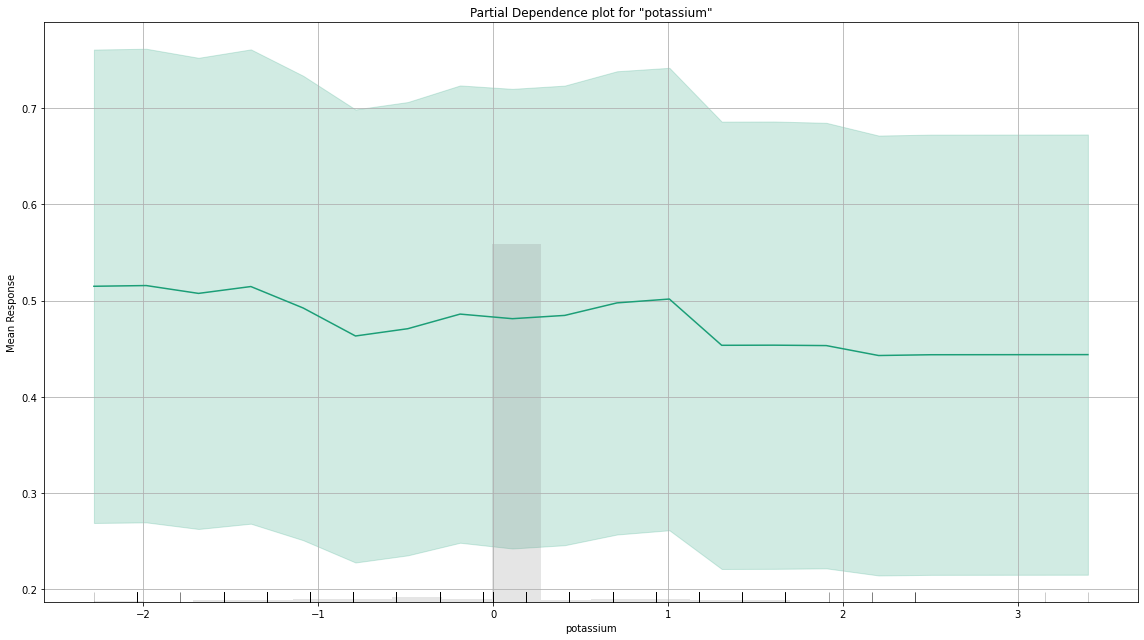

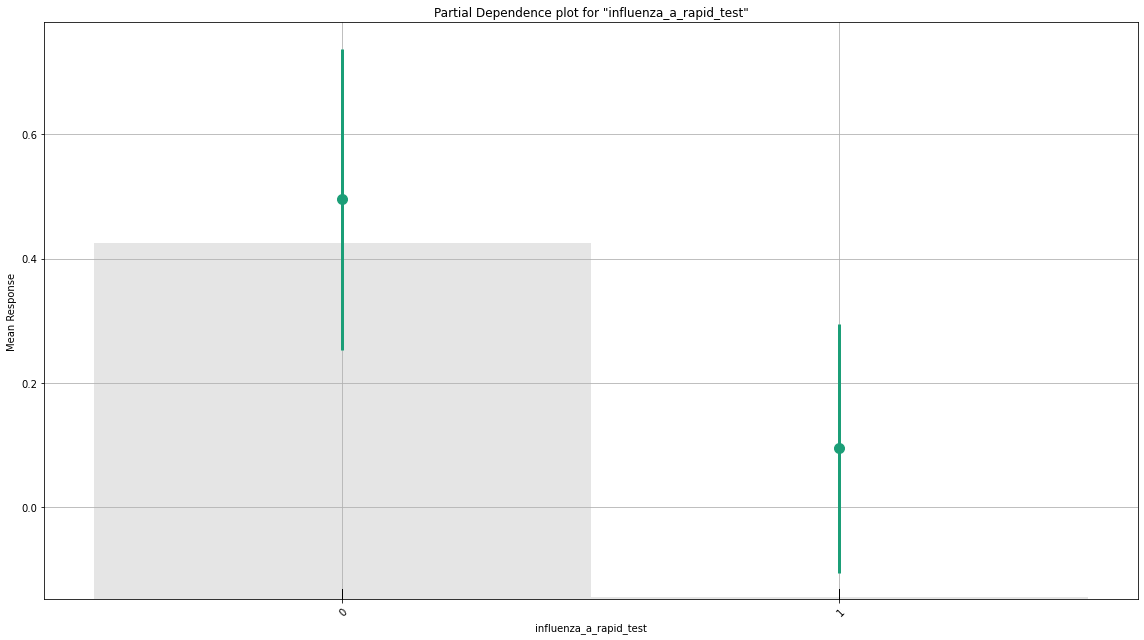

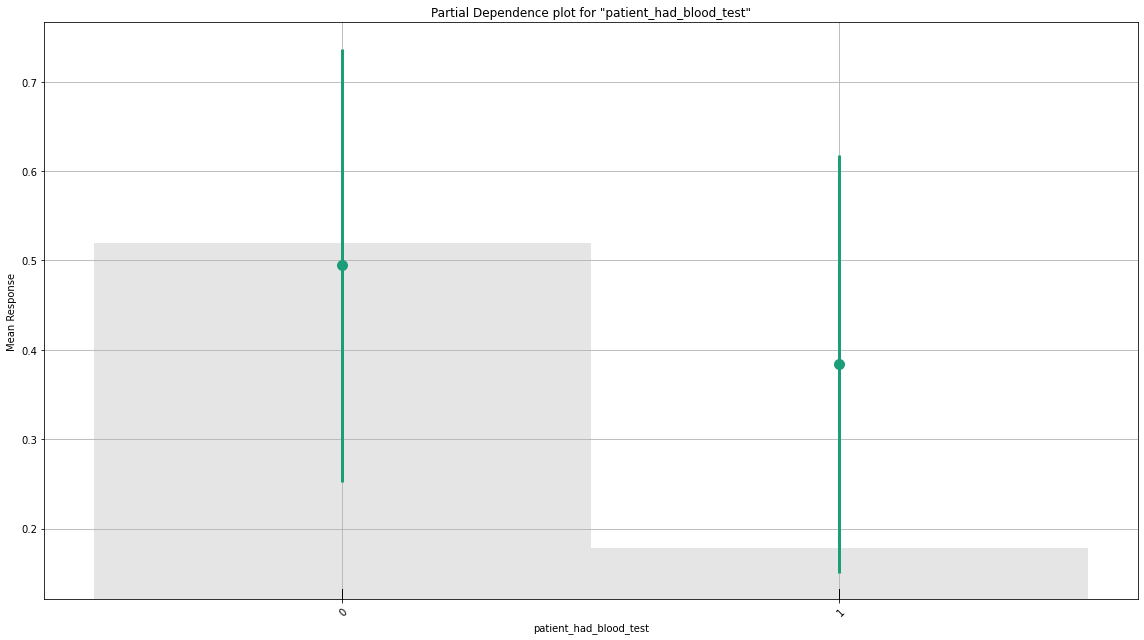

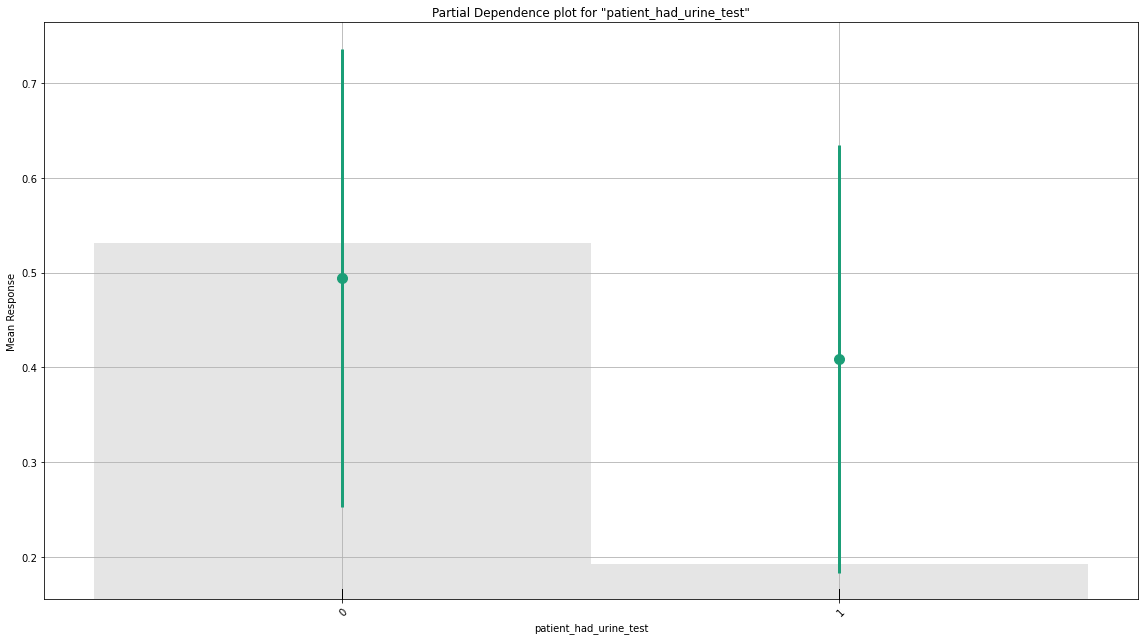

In [35]:
aml_leader.explain(train_h2o, exclude_explanations=['leaderboard', 'ice'], top_n_features = 30, render=False)

---
## Model Explanation

This is most important when the best model is a stacked ensemble model.

In [36]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(mls.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

C:\Users\kingl\anaconda3\lib\site-packages\h2o\estimators\stackedensemble.py:832: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  warnings.warn(


In [37]:
metalearner

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  metalearner_AUTO_StackedEnsemble_AllModels_AutoML_20211004_145453


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 0.002113 )",22,6,6,levelone_training_StackedEnsemble_AllModels_AutoML_20211004_145453




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19247766583746662
RMSE: 0.43872276649094316
LogLoss: 0.5453082129791268
Null degrees of freedom: 8137
Residual degrees of freedom: 8131
Null deviance: 11281.663510795215
Residual deviance: 8875.436474448268
AIC: 8889.436474448268
AUC: 0.74384609405185
AUCPR: 0.738708753045457
Gini: 0.48769218810369996

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3605443366603845: 


,,0,1,Error,Rate
0,0,1563.0,2506.0,0.6159,(2506.0/4069.0)
1,1,212.0,3857.0,0.0521,(212.0/4069.0)
2,Total,1775.0,6363.0,0.334,(2718.0/8138.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.360544,0.739456,166.0
1,max f2,0.282481,0.868974,184.0
2,max f0point5,0.534588,0.663449,119.0
3,max accuracy,0.498911,0.668469,137.0
4,max precision,0.999241,1.000000,0.0
5,max recall,0.040763,1.000000,287.0
6,max specificity,0.999241,1.000000,0.0
7,max absolute_mcc,0.360544,0.401999,166.0
8,max min_per_class_accuracy,0.546243,0.658147,112.0
9,max mean_per_class_accuracy,0.498911,0.668469,137.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.00 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010199,0.998831,2.000000,2.000000,1.000000,0.998990,1.000000,0.998990,0.020398,0.020398,100.000000,100.000000,0.020398
1,2,0.020029,0.998585,2.000000,2.000000,1.000000,0.998695,1.000000,0.998845,0.019661,0.040059,100.000000,100.000000,0.040059
2,3,0.030229,0.998356,2.000000,2.000000,1.000000,0.998453,1.000000,0.998713,0.020398,0.060457,100.000000,100.000000,0.060457
3,4,0.040305,0.998035,2.000000,2.000000,1.000000,0.998162,1.000000,0.998575,0.020152,0.080609,100.000000,100.000000,0.080609
4,5,0.050258,0.997632,2.000000,2.000000,1.000000,0.997841,1.000000,0.998430,0.019907,0.100516,100.000000,100.000000,0.100516
5,6,0.105800,0.658685,1.557522,1.767712,0.778761,0.822632,0.883856,0.906141,0.086508,0.187024,55.752212,76.771196,0.162448
6,7,0.160113,0.625970,1.221719,1.582502,0.610860,0.630744,0.791251,0.812721,0.066355,0.253379,22.171946,58.250192,0.186532
7,8,0.204964,0.610226,1.145205,1.486811,0.572603,0.614918,0.743405,0.769437,0.051364,0.304743,14.520548,48.681055,0.199558
8,9,0.304497,0.600007,1.237037,1.405165,0.618519,0.604261,0.702583,0.715445,0.123126,0.427869,23.703704,40.516546,0.246744
9,10,0.406242,0.577861,1.227053,1.360557,0.613527,0.588139,0.680278,0.683561,0.124846,0.552716,22.705314,36.055656,0.292947




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.1927141992041688
RMSE: 0.438992254150536
LogLoss: 0.5459744233863822
Null degrees of freedom: 8137
Residual degrees of freedom: 8132
Null deviance: 11285.279962716224
Residual deviance: 8886.279715036759
AIC: 8898.279715036759
AUC: 0.7422617261914936
AUCPR: 0.7370860831629653
Gini: 0.4845234523829871

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37229910389703613: 


,,0,1,Error,Rate
0,0,1561.0,2508.0,0.6164,(2508.0/4069.0)
1,1,213.0,3856.0,0.0523,(213.0/4069.0)
2,Total,1774.0,6364.0,0.3344,(2721.0/8138.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.372299,0.739193,244.0
1,max f2,0.279174,0.868898,285.0
2,max f0point5,0.522816,0.662115,163.0
3,max accuracy,0.488320,0.668223,200.0
4,max precision,0.999352,1.000000,0.0
5,max recall,0.039051,1.000000,359.0
6,max specificity,0.999352,1.000000,0.0
7,max absolute_mcc,0.372299,0.401188,244.0
8,max min_per_class_accuracy,0.544329,0.658393,144.0
9,max mean_per_class_accuracy,0.488320,0.668223,200.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.01 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010076,0.999121,2.000000,2.000000,1.000000,0.999293,1.000000,0.999293,0.020152,0.020152,100.000000,100.000000,0.020152
1,2,0.020029,0.998749,2.000000,2.000000,1.000000,0.998931,1.000000,0.999113,0.019907,0.040059,100.000000,100.000000,0.040059
2,3,0.030106,0.998451,1.975610,1.991837,0.987805,0.998597,0.995918,0.998941,0.019907,0.059966,97.560976,99.183673,0.059720
3,4,0.040059,0.998103,2.000000,1.993865,1.000000,0.998292,0.996933,0.998780,0.019907,0.079872,100.000000,99.386503,0.079626
4,5,0.050012,0.997605,2.000000,1.995086,1.000000,0.997855,0.997543,0.998596,0.019907,0.099779,100.000000,99.508600,0.099533
5,6,0.100516,0.661694,1.586375,1.789731,0.793187,0.840508,0.894866,0.919165,0.080118,0.179897,58.637470,78.973105,0.158761
6,7,0.150897,0.623943,1.214634,1.597720,0.607317,0.634431,0.798860,0.824099,0.061194,0.241091,21.463415,59.771987,0.180388
7,8,0.201032,0.611755,1.230392,1.506112,0.615196,0.617537,0.753056,0.772585,0.061686,0.302777,23.039216,50.611247,0.203490
8,9,0.301303,0.598282,1.169118,1.393964,0.584559,0.604859,0.696982,0.716768,0.117228,0.420005,16.911765,39.396411,0.237405
9,10,0.400590,0.575663,1.262376,1.361350,0.631188,0.588222,0.680675,0.684907,0.125338,0.545343,26.237624,36.134969,0.289506




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.6609239,0.014229897,0.6500608,0.6483384,0.653548,0.67490953,0.677763
1,auc,0.7427606,0.0070722764,0.74490386,0.7413432,0.74105847,0.75299793,0.73349965
2,aucpr,0.73770887,0.010653189,0.72447914,0.73389226,0.74807405,0.7492535,0.7328454
3,err,0.33907607,0.014229897,0.34993926,0.35166162,0.346452,0.32509047,0.322237
4,err_count,552.4,42.158035,576.0,582.0,581.0,539.0,484.0
5,f0point5,0.64925206,0.01579412,0.63006073,0.6374094,0.64987564,0.6608187,0.66809577
6,f1,0.7401491,0.012599571,0.7217391,0.73545456,0.74212164,0.7458746,0.75555557
7,f2,0.8608192,0.010526865,0.84464043,0.8691448,0.86488724,0.8560606,0.86936307
8,lift_top_group,2.0007365,0.06434159,2.0994897,2.0232275,1.95,1.9903961,1.9405684
9,logloss,0.54605365,0.0046810247,0.55024165,0.5436024,0.5471713,0.5392053,0.5500475



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective,alpha,lambda,deviance_train,deviance_xval,deviance_se,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-10-04 14:55:54,0.000 sec,5,4437.822561,0.546766,0.5,0.002113,1.090642,1.092033,0.488390,0.438710,0.545321,0.230135,0.743983,0.738833,2.0,0.333989
1,,2021-10-04 14:55:54,0.040 sec,6,4437.874617,0.547753,1.0,0.002113,1.090655,1.092107,0.488423,0.438723,0.545308,0.230089,0.743846,0.738709,2.0,0.333989



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,GBM_grid__1_AutoML_20211004_145453_model_1,0.805341,1.000000,0.320879
1,GBM_grid__1_AutoML_20211004_145453_model_7,0.731067,0.907773,0.291285
2,DRF_1_AutoML_20211004_145453,0.479937,0.595942,0.191225
3,GBM_grid__1_AutoML_20211004_145453_model_3,0.407016,0.505396,0.162171
4,XRT_1_AutoML_20211004_145453,0.071461,0.088734,0.028473
5,DeepLearning_1_AutoML_20211004_145453,0.014976,0.018596,0.005967
6,GBM_3_AutoML_20211004_145453,0.000000,0.000000,0.000000
7,GBM_4_AutoML_20211004_145453,0.000000,0.000000,0.000000
8,GBM_grid__1_AutoML_20211004_145453_model_6,0.000000,0.000000,0.000000
9,GBM_2_AutoML_20211004_145453,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


## Testing data
Let's look at the test data to gauge how well the model does on unseen data.  We should be extremely careful about using this data to _choose_ the model, but let's just make sure our model isn't completely failing on the unseen data.

In [38]:
test_perf, test_preds = basic_performance(aml_leader, test_h2o, show_outputs=True)

stackedensemble prediction progress: |████████████████████████████████████| 100%

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.20600394222112944
RMSE: 0.45387657157109296
LogLoss: 0.5750339401668219
Null degrees of freedom: 1128
Residual degrees of freedom: 1122
Null deviance: 1565.126333704316
Residual deviance: 1298.426636896684
AIC: 1312.426636896684
AUC: 0.6554905885658098
AUCPR: 0.2245794791971279
Gini: 0.31098117713161955

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5827225560660048: 


,,0,1,Error,Rate
0,0,786.0,231.0,0.2271,(231.0/1017.0)
1,1,67.0,45.0,0.5982,(67.0/112.0)
2,Total,853.0,276.0,0.264,(298.0/1129.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.582723,0.231959,21.0
1,max f2,0.181639,0.419968,46.0
2,max f0point5,0.755480,0.284091,15.0
3,max accuracy,0.920839,0.906112,5.0
4,max precision,0.989166,1.000000,0.0
5,max recall,0.001180,1.000000,175.0
6,max specificity,0.989166,1.000000,0.0
7,max absolute_mcc,0.834842,0.221616,9.0
8,max min_per_class_accuracy,0.529177,0.571429,26.0
9,max mean_per_class_accuracy,0.181639,0.625132,46.0



Gains/Lift Table: Avg response rate:  9.92 %, avg score: 39.31 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010629,0.831149,6.720238,6.720238,0.666667,0.911163,0.666667,0.911163,0.071429,0.071429,572.023810,572.023810,0.067495
1,2,0.031887,0.660162,2.100074,3.640129,0.208333,0.683654,0.361111,0.759490,0.044643,0.116071,110.007440,264.012897,0.093456
2,3,0.088574,0.620869,0.945033,1.915268,0.093750,0.620869,0.190000,0.670773,0.053571,0.169643,-5.496652,91.526786,0.089997
3,4,0.115146,0.617503,1.680060,1.860989,0.166667,0.617503,0.184615,0.658480,0.044643,0.214286,68.005952,86.098901,0.110058
4,5,0.156776,0.601257,0.857903,1.594633,0.085106,0.601257,0.158192,0.643285,0.035714,0.250000,-14.209726,59.463277,0.103491
5,6,0.244464,0.582723,1.730970,1.643536,0.171717,0.586158,0.163043,0.622794,0.151786,0.401786,73.097042,64.353649,0.174647
6,7,0.325952,0.553776,1.095691,1.506575,0.108696,0.569355,0.149457,0.609434,0.089286,0.491071,9.569099,50.657512,0.183303
7,8,0.408326,0.529177,0.975518,1.399442,0.096774,0.534686,0.138829,0.594355,0.080357,0.571429,-2.448157,39.944221,0.181065
8,9,0.546501,0.498227,1.292353,1.372366,0.128205,0.507006,0.136143,0.572270,0.178571,0.750000,29.235348,37.236629,0.225910
9,10,0.635075,0.463307,0.705625,1.279376,0.070000,0.471985,0.126918,0.558283,0.062500,0.812500,-29.437500,27.937587,0.196964


In [39]:
h2o.cluster().shutdown()

H2O session _sid_aa66 closed.
